In [3]:
import pandas as pd                                    # Working with tables
import numpy as np


from tiingo import TiingoClient                       # Stock prices.
import quandl                                         # Economic data, futures prices, ...

# API keys:
tiingo = TiingoClient({'api_key':'349dd4117e5d1ed71a22f0207a8e439cf3f7b06b'})
quandl.ApiConfig.api_key = '_ci7hzC_sPkspKWz2yzt'                      # Replace the XXXX with your API key (must be inside the ' ').

import matplotlib.pyplot as plt                        # Basic plot library.
plt.style.use('ggplot')                                # Make plots look nice.
%matplotlib inline

# Base Portfolio

In [94]:
tickers    = ['ASX','AGG']
start_ytd  = '3-23-2020'
end_ytd    = '3-23-2022'

Now let's look at the returns

In [95]:

prices  = tiingo.get_dataframe(tickers, start_ytd, end_ytd, metric_name='adjClose')
prices.index = pd.to_datetime(prices.index).tz_convert(None) 
r_base = prices.pct_change()
    
r_base.count()


ASX    505
AGG    505
dtype: int64

In [96]:
rf = 0.011
risk_premiums = r_base.mean() * 252 - rf  
risk_premiums

ASX    0.519198
AGG   -0.016032
dtype: float64

In [97]:
vol           = r_base.std()  * 252**0.5
vol

ASX    0.426452
AGG    0.040639
dtype: float64

In [98]:
corr          = r_base.corr()
corr

,ASX,AGG
ASX,1.000000,0.067594
AGG,0.067594,1.000000


In [99]:
cov           = r_base.cov()  * 252
cov

,ASX,AGG
ASX,0.181861,0.001171
AGG,0.001171,0.001652


Now we can make a mean-volatility plot to see where these two stocks stand.

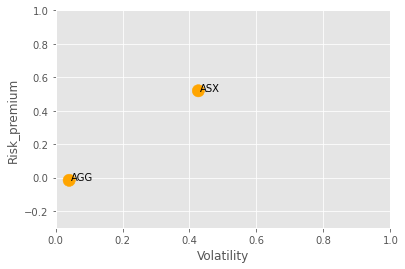

In [100]:
assets = pd.DataFrame()                        
assets['Risk_premium'] = risk_premiums
assets['Volatility']   = vol    
assets['Color']        = 'orange'
assets['Size']         = 150

all_portfolios = assets
all_portfolios
    
graph = all_portfolios.plot.scatter('Volatility','Risk_premium', color=all_portfolios.Color, s=all_portfolios.Size, xlim=(0,1), ylim=(-0.3,1))

    # add ticker symbols to plot:
for s in tickers:                                 # loop over sectors
    x = all_portfolios.loc[s,'Volatility']+0.005  # get x-coordinate from table (+ offset so the labels don't overlap with points)
    y = all_portfolios.loc[s,'Risk_premium']      # get y-coordinate from table
    graph.text(x,y,s)                             # add the ticker symbol to the graph

We can also make an efficient frontier plot to see how different weighted combinations of these stocks would land on the mean-volatility plot.

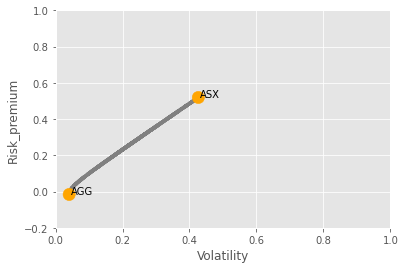

In [101]:
   
# here we are building the simulation that finds the possible portfolios
n_portfolios = 1000

random_arrays  = [ np.random.uniform(0,1,len(tickers)) for i in range(0,n_portfolios) ]
random_weights = [ ra/ra.sum() for ra in random_arrays ]
    
random = pd.DataFrame()
random['Risk_premium'] = [ w.dot(risk_premiums)   for w in random_weights ]
random['Volatility']   = [ w.dot(cov).dot(w)**0.5 for w in random_weights ]
random['Color']        = 'gray'
random['Size']         = 10
random['sharpe']       = random['Risk_premium']/random['Volatility']

all_portfolios = pd.concat([random, assets])
    
graph = all_portfolios.plot.scatter('Volatility','Risk_premium', color=all_portfolios.Color, s=all_portfolios.Size, xlim=(0,1), ylim=(-0.2,1))

# add ticker to plot:
for s in tickers:                                 # loop over sectors
    x = all_portfolios.loc[s,'Volatility']+0.005  # get x-coordinate from table (+ offset so the labels don't overlap with points)
    y = all_portfolios.loc[s,'Risk_premium']      # get y-coordinate from table
    graph.text(x,y,s)                             # add the ticker symbol to the graph


Time to find the weights that correspond to the maximum sharpe ratio portfolio.

In [102]:

random['weights'] = random_weights
wgts = random[(random['sharpe'] >= random.sharpe.max())].weights.astype(str)

rp = random[(random['sharpe'] == random.sharpe.max())].Risk_premium
#now I have found the weights, but they are in string form. We want them to be a panda series
#here i am turning the string weights into a list
lw = list(wgts)
#finding the first entry in the list(the first entry is always a quote)
ws = str(lw[0])
# replacing the quote with a blank
ws = ws.replace('[','')
ws = ws.replace(']','')
#deliniating the list values by spaces
lw = ws.split(' ')
#filtering out the bad data
lw = list(filter(None, lw))
#Finally turning the list into a numpy array
nw = np.array(lw)
nw = nw.astype(float)
    
#now we have to turn the numpy array into a panda series 
    
sharpe_weights                  = pd.DataFrame()
sharpe_weights['Risk_Premiums'] = risk_premiums
sharpe_weights['Weights']       = nw
sharpe_weights['weighted_ret']  = sharpe_weights['Weights']*sharpe_weights['Risk_Premiums']
sharpe_weights

,Risk_Premiums,Weights,weighted_ret
ASX,0.519198,0.998068,0.518195
AGG,-0.016032,0.001932,-0.000031


In [51]:
rf = 0.011
r_base*sharpe_weights['Weights']
r_base['total_ret'] = r_base.ASX + r_base.AGG
r_base

,ASX,AGG,btcusd,total_ret
2020-03-23,NaN,NaN,NaN,NaN
2020-03-24,0.140187,0.008256,NaN,0.148443
2020-03-25,0.051913,0.010214,-0.010413,0.062127
2020-03-26,0.031169,0.003051,0.009031,0.034219
2020-03-27,-0.098237,0.004258,-0.056186,-0.093979
...,...,...,...,...
2022-03-20,0.000000,0.000000,-0.022298,0.000000
2022-03-21,-0.018445,-0.009806,-0.006325,-0.028251
2022-03-22,0.006711,-0.002709,0.033207,0.004002
2022-03-23,-0.029333,0.004122,0.012255,-0.025212


In [18]:
max_rp = r.total_ret.mean()*54 - 0.011
max_rp

0.10153557506416473

In [19]:
max_vol = r.total_ret.std()*54**0.5
max_vol

0.19956518488641317

In [20]:
max_sharpe = max_rp/max_vol
max_sharpe

0.5087840102067698

# With Bitcoin

In [21]:
tickers = ['ASX','AGG','btcusd']

In [22]:

prices  = tiingo.get_dataframe(tickers, start_ytd, end_ytd, metric_name='adjClose')
prices.index = pd.to_datetime(prices.index).tz_convert(None) 
r = prices.pct_change()
    
r


,ASX,AGG,btcusd
2020-03-23,NaN,NaN,NaN
2020-03-24,0.140187,0.008256,NaN
2020-03-25,0.051913,0.010214,-0.010413
2020-03-26,0.031169,0.003051,0.009031
2020-03-27,-0.098237,0.004258,-0.056186
...,...,...,...
2022-03-20,0.000000,0.000000,-0.022298
2022-03-21,-0.018445,-0.009806,-0.006325
2022-03-22,0.006711,-0.002709,0.033207
2022-03-23,-0.029333,0.004122,0.012255


In [25]:
rf = 0.011
risk_premiums = r.mean() * 252 - rf  
risk_premiums

ASX       0.355279
AGG      -0.014476
btcusd    0.812330
dtype: float64

In [26]:
vol           = r.std()  * 252**0.5
vol

ASX       0.354680
AGG       0.033768
btcusd    0.594495
dtype: float64

In [27]:
corr          = r.corr()
corr

,ASX,AGG,btcusd
ASX,1.000000,0.067340,0.275524
AGG,0.067340,1.000000,0.012825
btcusd,0.275524,0.012825,1.000000


In [28]:
cov           = r.cov()  * 252
cov

,ASX,AGG,btcusd
ASX,0.125798,0.000807,0.056577
AGG,0.000807,0.001140,0.000255
btcusd,0.056577,0.000255,0.353424


Now we can make a mean-volatility plot to see where these two stocks stand.

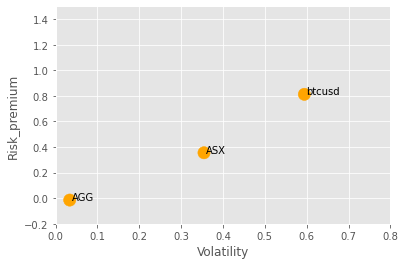

In [34]:
assets = pd.DataFrame()                        
assets['Risk_premium'] = risk_premiums
assets['Volatility']   = vol    
assets['Color']        = 'orange'
assets['Size']         = 150

all_portfolios = assets
all_portfolios
    
graph = all_portfolios.plot.scatter('Volatility','Risk_premium', color=all_portfolios.Color, s=all_portfolios.Size, xlim=(0,0.8), ylim=(-0.2,1.5))

    # add ticker symbols to plot:
for s in tickers:                                 # loop over sectors
    x = all_portfolios.loc[s,'Volatility']+0.005  # get x-coordinate from table (+ offset so the labels don't overlap with points)
    y = all_portfolios.loc[s,'Risk_premium']      # get y-coordinate from table
    graph.text(x,y,s)                             # add the ticker symbol to the graph

We can also make an efficient frontier plot to see how different weighted combinations of these stocks would land on the mean-volatility plot.

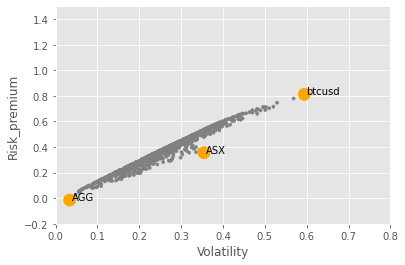

In [33]:
   
# here we are building the simulation that finds the possible portfolios
n_portfolios = 1000

random_arrays  = [ np.random.uniform(0,1,len(tickers)) for i in range(0,n_portfolios) ]
random_weights = [ ra/ra.sum() for ra in random_arrays ]
    
random = pd.DataFrame()
random['Risk_premium'] = [ w.dot(risk_premiums)   for w in random_weights ]
random['Volatility']   = [ w.dot(cov).dot(w)**0.5 for w in random_weights ]
random['Color']        = 'gray'
random['Size']         = 10
random['sharpe']       = random['Risk_premium']/random['Volatility']

all_portfolios = pd.concat([random, assets])
    
graph = all_portfolios.plot.scatter('Volatility','Risk_premium', color=all_portfolios.Color, s=all_portfolios.Size, xlim=(0,.8), ylim=(-0.2,1.5))

# add ticker to plot:
for s in tickers:                                 # loop over sectors
    x = all_portfolios.loc[s,'Volatility']+0.005  # get x-coordinate from table (+ offset so the labels don't overlap with points)
    y = all_portfolios.loc[s,'Risk_premium']      # get y-coordinate from table
    graph.text(x,y,s)                             # add the ticker symbol to the graph


Time to find the weights that correspond to the maximum sharpe ratio portfolio.

In [35]:

random['weights'] = random_weights
wgts = random[(random['sharpe'] >= random.sharpe.max())].weights.astype(str)

rp = random[(random['sharpe'] == random.sharpe.max())].Risk_premium
#now I have found the weights, but they are in string form. We want them to be a panda series
#here i am turning the string weights into a list
lw = list(wgts)
#finding the first entry in the list(the first entry is always a quote)
ws = str(lw[0])
# replacing the quote with a blank
ws = ws.replace('[','')
ws = ws.replace(']','')
#deliniating the list values by spaces
lw = ws.split(' ')
#filtering out the bad data
lw = list(filter(None, lw))
#Finally turning the list into a numpy array
nw = np.array(lw)
nw = nw.astype(float)
    
#now we have to turn the numpy array into a panda series 
    
sharpe_weights                  = pd.DataFrame()
sharpe_weights['Risk_Premiums'] = risk_premiums
sharpe_weights['Weights']       = nw
sharpe_weights['weighted_ret']  = sharpe_weights['Weights']*sharpe_weights['Risk_Premiums']
sharpe_weights

,Risk_Premiums,Weights,weighted_ret
ASX,0.355279,0.498202,0.177001
AGG,-0.014476,0.000491,-0.000007
btcusd,0.812330,0.501306,0.407226


In [36]:
rf = 0.011
r*sharpe_weights['Weights']
r['total_ret'] = r.ASX + r.AGG + r.btcusd
r

,ASX,AGG,btcusd,total_ret
2020-03-23,NaN,NaN,NaN,NaN
2020-03-24,0.140187,0.008256,NaN,NaN
2020-03-25,0.051913,0.010214,-0.010413,0.051713
2020-03-26,0.031169,0.003051,0.009031,0.043251
2020-03-27,-0.098237,0.004258,-0.056186,-0.150165
...,...,...,...,...
2022-03-20,0.000000,0.000000,-0.022298,-0.022298
2022-03-21,-0.018445,-0.009806,-0.006325,-0.034576
2022-03-22,0.006711,-0.002709,0.033207,0.037209
2022-03-23,-0.029333,0.004122,0.012255,-0.012956


In [37]:
max_rp = r.total_ret.mean()*252 - 0.011
max_rp

1.1243858584075728

In [38]:
max_vol = r.total_ret.std()*252**0.5
max_vol

0.7670304383949123

In [39]:
max_sharpe = max_rp/max_vol
max_sharpe

1.4658947052485458

Vary the amount of BTC/ GLD in the portfolio

In [41]:
var_weight = []
for i in range(100):
    var_weight.append(i/100)
var_weight  = np.array(var_weight)
base_weight = 1 - var_weight
base_weight
    

array([1.  , 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9 ,
       0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8 , 0.79,
       0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69, 0.68,
       0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59, 0.58, 0.57,
       0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5 , 0.49, 0.48, 0.47, 0.46,
       0.45, 0.44, 0.43, 0.42, 0.41, 0.4 , 0.39, 0.38, 0.37, 0.36, 0.35,
       0.34, 0.33, 0.32, 0.31, 0.3 , 0.29, 0.28, 0.27, 0.26, 0.25, 0.24,
       0.23, 0.22, 0.21, 0.2 , 0.19, 0.18, 0.17, 0.16, 0.15, 0.14, 0.13,
       0.12, 0.11, 0.1 , 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02,
       0.01])

In [53]:
test_returns                   = pd.DataFrame()
test_returns['Base_Portfolio'] = r_base.total_ret
test_returns['btcusd']         = r.btcusd
test_returns

,Base_Portfolio,btcusd
2020-03-23,NaN,NaN
2020-03-24,0.148443,NaN
2020-03-25,0.062127,-0.010413
2020-03-26,0.034219,0.009031
2020-03-27,-0.093979,-0.056186
...,...,...
2022-03-20,0.000000,-0.022298
2022-03-21,-0.028251,-0.006325
2022-03-22,0.004002,0.033207
2022-03-23,-0.025212,0.012255


In [58]:
Volatility   = []
Risk_Premium = []
Sharpe_Ratio = []

test_port_returns = []

for w in var_weight:
    var_weighted_return  = test_returns.btcusd*w
    base_weighted_return = test_returns.Base_Portfolio*(1-w)
    
    total_ret = var_weighted_return + base_weighted_return
    total_ret = pd.DataFrame(total_ret)
    
    return_average    = total_ret.mean()*252
    return_volatility = total_ret.std()*252**0.5
    return_rp         = return_average - 0.011
    return_sharpe     = return_rp/return_volatility
    
    test_port_returns.append(return_average)
    Volatility.append(return_volatility)
    Risk_Premium.append(return_rp)
    
    
    

Risk_Premium = pd.DataFrame(Risk_Premium)
Volatility   = pd.DataFrame(Volatility)



In [59]:
var_test_results                 = pd.DataFrame()
var_test_results['var_weight']   = var_weight
var_test_results['Risk_Premium'] = Risk_Premium
var_test_results['Volatility']   = Volatility
var_test_results['Sharpe_Ratio'] = var_test_results.Risk_Premium/var_test_results.Volatility
var_test_results

,var_weight,Risk_Premium,Volatility,Sharpe_Ratio
0,0.00,0.301056,0.348205,0.864594
1,0.01,0.306169,0.346403,0.883853
2,0.02,0.311282,0.344695,0.903064
3,0.03,0.316395,0.343085,0.922206
4,0.04,0.321507,0.341572,0.941258
...,...,...,...,...
95,0.95,0.786766,0.569796,1.380785
96,0.96,0.791879,0.574695,1.377911
97,0.97,0.796991,0.579615,1.375036
98,0.98,0.802104,0.584555,1.372161


<AxesSubplot:>

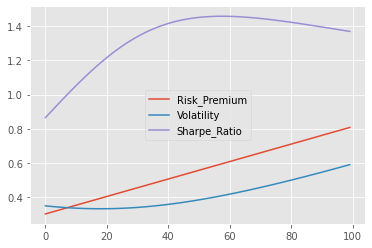

In [60]:
var_test_results[['Risk_Premium','Volatility','Sharpe_Ratio']].plot(logy = False)

0.5

# With Gold

In [61]:
tickers = ['ASX','AGG','GLD']

In [62]:

prices  = tiingo.get_dataframe(tickers, start_ytd, end_ytd, metric_name='adjClose')
prices.index = pd.to_datetime(prices.index).tz_convert(None) 
r = prices.pct_change()
    
r.count()


ASX    505
AGG    505
GLD    505
dtype: int64

In [63]:
rf = 0.011
risk_premiums = r.mean() * 252 - rf  
risk_premiums

ASX    0.519198
AGG   -0.016032
GLD    0.110433
dtype: float64

In [64]:
vol           = r.std()  * 252**0.5
vol

ASX    0.426452
AGG    0.040639
GLD    0.160955
dtype: float64

In [65]:
corr          = r.corr()
corr

,ASX,AGG,GLD
ASX,1.000000,0.067594,0.158446
AGG,0.067594,1.000000,0.308635
GLD,0.158446,0.308635,1.000000


In [66]:
cov           = r.cov()  * 252
cov

,ASX,AGG,GLD
ASX,0.181861,0.001171,0.010876
AGG,0.001171,0.001652,0.002019
GLD,0.010876,0.002019,0.025907


Now we can make a mean-volatility plot to see where these two stocks stand.

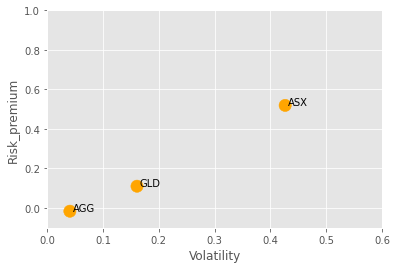

In [70]:
assets = pd.DataFrame()                        
assets['Risk_premium'] = risk_premiums
assets['Volatility']   = vol    
assets['Color']        = 'orange'
assets['Size']         = 150

all_portfolios = assets
all_portfolios
    
graph = all_portfolios.plot.scatter('Volatility','Risk_premium', color=all_portfolios.Color, s=all_portfolios.Size, xlim=(0,0.6), ylim=(-0.1,1))

    # add ticker symbols to plot:
for s in tickers:                                 # loop over sectors
    x = all_portfolios.loc[s,'Volatility']+0.005  # get x-coordinate from table (+ offset so the labels don't overlap with points)
    y = all_portfolios.loc[s,'Risk_premium']      # get y-coordinate from table
    graph.text(x,y,s)                             # add the ticker symbol to the graph

We can also make an efficient frontier plot to see how different weighted combinations of these stocks would land on the mean-volatility plot.

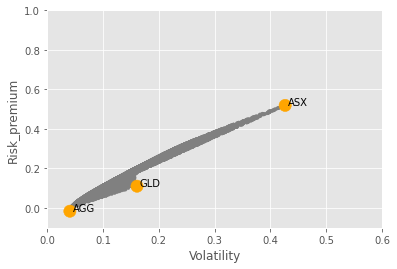

In [73]:
   
# here we are building the simulation that finds the possible portfolios
n_portfolios = 10000

random_arrays  = [ np.random.uniform(0,1,len(tickers)) for i in range(0,n_portfolios) ]
random_weights = [ ra/ra.sum() for ra in random_arrays ]
    
random = pd.DataFrame()
random['Risk_premium'] = [ w.dot(risk_premiums)   for w in random_weights ]
random['Volatility']   = [ w.dot(cov).dot(w)**0.5 for w in random_weights ]
random['Color']        = 'gray'
random['Size']         = 10
random['sharpe']       = random['Risk_premium']/random['Volatility']

all_portfolios = pd.concat([random, assets])
    
graph = all_portfolios.plot.scatter('Volatility','Risk_premium', color=all_portfolios.Color, s=all_portfolios.Size, xlim=(0,.6), ylim=(-0.1,1))

# add ticker to plot:
for s in tickers:                                 # loop over sectors
    x = all_portfolios.loc[s,'Volatility']+0.005  # get x-coordinate from table (+ offset so the labels don't overlap with points)
    y = all_portfolios.loc[s,'Risk_premium']      # get y-coordinate from table
    graph.text(x,y,s)                             # add the ticker symbol to the graph


Time to find the weights that correspond to the maximum sharpe ratio portfolio.

In [74]:

random['weights'] = random_weights
wgts = random[(random['sharpe'] >= random.sharpe.max())].weights.astype(str)

rp = random[(random['sharpe'] == random.sharpe.max())].Risk_premium
#now I have found the weights, but they are in string form. We want them to be a panda series
#here i am turning the string weights into a list
lw = list(wgts)
#finding the first entry in the list(the first entry is always a quote)
ws = str(lw[0])
# replacing the quote with a blank
ws = ws.replace('[','')
ws = ws.replace(']','')
#deliniating the list values by spaces
lw = ws.split(' ')
#filtering out the bad data
lw = list(filter(None, lw))
#Finally turning the list into a numpy array
nw = np.array(lw)
nw = nw.astype(float)
    
#now we have to turn the numpy array into a panda series 
    
sharpe_weights                  = pd.DataFrame()
sharpe_weights['Risk_Premiums'] = risk_premiums
sharpe_weights['Weights']       = nw
sharpe_weights['weighted_ret']  = sharpe_weights['Weights']*sharpe_weights['Risk_Premiums']
sharpe_weights

,Risk_Premiums,Weights,weighted_ret
ASX,0.519198,0.464575,0.241206
AGG,-0.016032,0.001173,-0.000019
GLD,0.110433,0.534252,0.058999


In [78]:
rf = 0.011
r*sharpe_weights['Weights']
r['total_ret'] = r.ASX + r.AGG + r.GLD
r

,ASX,AGG,GLD,total_ret
2020-03-23,NaN,NaN,NaN,NaN
2020-03-24,0.140187,0.008256,0.048530,0.196974
2020-03-25,0.051913,0.010214,-0.013690,0.048437
2020-03-26,0.031169,0.003051,0.012822,0.047042
2020-03-27,-0.098237,0.004258,-0.006460,-0.100439
...,...,...,...,...
2022-03-17,0.019048,0.001672,0.004889,0.025608
2022-03-18,0.013351,0.002225,-0.008790,0.006786
2022-03-21,-0.018445,-0.009806,0.007641,-0.020610
2022-03-22,0.006711,-0.002709,-0.007251,-0.003249


In [79]:
max_rp = r.total_ret.mean()*252 - 0.011
max_rp

0.6355989227488618

In [80]:
max_vol = r.total_ret.std()*252**0.5
max_vol

0.48739269026028464

In [81]:
max_sharpe = max_rp/max_vol
max_sharpe

1.3040797193930624

Vary the amount of BTC/ GLD in the portfolio

In [83]:
var_weight = []
for i in range(100):
    var_weight.append(i/100)
var_weight  = np.array(var_weight)
base_weight = 1 - var_weight
base_weight
    

array([1.  , 0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9 ,
       0.89, 0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8 , 0.79,
       0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69, 0.68,
       0.67, 0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59, 0.58, 0.57,
       0.56, 0.55, 0.54, 0.53, 0.52, 0.51, 0.5 , 0.49, 0.48, 0.47, 0.46,
       0.45, 0.44, 0.43, 0.42, 0.41, 0.4 , 0.39, 0.38, 0.37, 0.36, 0.35,
       0.34, 0.33, 0.32, 0.31, 0.3 , 0.29, 0.28, 0.27, 0.26, 0.25, 0.24,
       0.23, 0.22, 0.21, 0.2 , 0.19, 0.18, 0.17, 0.16, 0.15, 0.14, 0.13,
       0.12, 0.11, 0.1 , 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02,
       0.01])

In [85]:
test_returns                   = pd.DataFrame()
test_returns['Base_Portfolio'] = r_base.total_ret
test_returns['GLD']            = r.GLD
test_returns

,Base_Portfolio,GLD
2020-03-23,NaN,NaN
2020-03-24,0.148443,0.048530
2020-03-25,0.062127,-0.013690
2020-03-26,0.034219,0.012822
2020-03-27,-0.093979,-0.006460
...,...,...
2022-03-20,0.000000,NaN
2022-03-21,-0.028251,0.007641
2022-03-22,0.004002,-0.007251
2022-03-23,-0.025212,0.013660


In [90]:
Volatility   = []
Risk_Premium = []
Sharpe_Ratio = []

test_port_returns = []

for w in var_weight:
    var_weighted_return  = test_returns.GLD*w
    base_weighted_return = test_returns.Base_Portfolio*(1-w)
    
    total_ret = var_weighted_return + base_weighted_return
    total_ret = pd.DataFrame(total_ret)
    
    return_average    = total_ret.mean()*252
    return_volatility = total_ret.std()*252**0.5
    return_rp         = return_average - 0.011
    return_sharpe     = return_rp/return_volatility
    
    test_port_returns.append(return_average)
    Volatility.append(return_volatility)
    Risk_Premium.append(return_rp)
    
    
    

Risk_Premium = pd.DataFrame(Risk_Premium)
Volatility   = pd.DataFrame(Volatility)



In [91]:
var_test_results                 = pd.DataFrame()
var_test_results['var_weight']   = var_weight
var_test_results['Risk_Premium'] = Risk_Premium
var_test_results['Volatility']   = Volatility
var_test_results['Sharpe_Ratio'] = var_test_results.Risk_Premium/var_test_results.Volatility
var_test_results

,var_weight,Risk_Premium,Volatility,Sharpe_Ratio
0,0.00,0.514166,0.431110,1.192656
1,0.01,0.510129,0.427101,1.194398
2,0.02,0.506091,0.423098,1.196157
3,0.03,0.502054,0.419101,1.197931
4,0.04,0.498017,0.415110,1.199721
...,...,...,...,...
95,0.95,0.130620,0.158336,0.824950
96,0.96,0.126582,0.158629,0.797975
97,0.97,0.122545,0.159039,0.770535
98,0.98,0.118508,0.159564,0.742698


<AxesSubplot:>

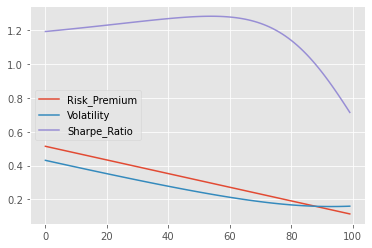

In [92]:
var_test_results[['Risk_Premium','Volatility','Sharpe_Ratio']].plot(logy = False)